In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import tqdm
import pandas as pd
import dataset_utils
import torchxrayvision as xrv

In [3]:
model = xrv.baseline_models.mi2rl.CheSS().cuda()

In [4]:
def extract_features(model: torch.nn.Module, dataset: torch.utils.data.Dataset, cuda=True):

    dl = torch.utils.data.DataLoader(
        dataset,
        batch_size=64,
        num_workers=1, 
        pin_memory=cuda,
    )
    
    d_feats = []
    with torch.inference_mode():
        for i, batch in enumerate(tqdm.tqdm(dl)):
            imgs = batch["img"]
            if cuda:
                imgs = imgs.cuda()
            if hasattr(model, "features2"):
                feats = model.features2(imgs)
            else:
                feats = model.features(imgs)
            feats = feats.detach().cpu().numpy()
            feats = feats.reshape(len(feats),-1)
            d_feats.append(feats)
    d_feats = np.concatenate(d_feats)
    return d_feats


In [5]:
transform = torchvision.transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(512),
])

In [6]:
pathos = ["Effusion", "Fibrosis", "Hernia", "Edema"]

In [7]:
dataset = dataset_utils.get_data("nih-pc", pathologies=pathos, transform=transform)

{'Support Devices', 'Atelectasis', 'Emphysema', 'Infiltration', 'Cardiomegaly', 'Costophrenic Angle Blunting', 'Hemidiaphragm Elevation', 'Bronchiectasis', 'Flattened Diaphragm', 'Scoliosis', 'Consolidation', 'Granuloma', 'Tube', 'Air Trapping', 'Aortic Atheromatosis', 'Pneumothorax', 'Mass', 'Pleural_Thickening', 'Tuberculosis', 'Fracture', 'Nodule', 'Aortic Elongation', 'Hilar Enlargement', 'Pneumonia'} will be dropped
{'Pneumothorax', 'Atelectasis', 'Emphysema', 'Infiltration', 'Cardiomegaly', 'Mass', 'Pleural_Thickening', 'Nodule', 'Consolidation', 'Pneumonia'} will be dropped
['Hernia', 'Fibrosis', 'Effusion', 'Edema']


In [8]:
# select samples with one element
dataset = xrv.datasets.SubsetDataset(dataset, idxs=np.where(np.sum(dataset.labels, axis=1) == 1)[0])

In [9]:
dataset

{'Edema': {0.0: 20051, 1.0: 2015},
 'Effusion': {0.0: 5805, 1.0: 16261},
 'Fibrosis': {0.0: 19948, 1.0: 2118},
 'Hernia': {0.0: 20394, 1.0: 1672}}


SubsetDataset num_samples=22066
└ of MergeDataset num_samples=206945
  ├0 PC_Dataset num_samples=94825 views=['PA', 'AP'] data_aug=None
  └1 NIH_Dataset num_samples=112120 views=['PA', 'AP'] data_aug=None
  

In [10]:
# load equal number of samples of each pathology
num_samples = 128
idxs = []
for path in pathos:
    path_idxs = dataset.labels[:,dataset.pathologies.index(path)] == 1
    np.random.seed(0)
    idxs.append(np.random.choice(np.where(path_idxs)[0], num_samples, replace=False))
idxs = np.concatenate(idxs)

In [11]:
dataset = xrv.datasets.SubsetDataset(dataset, idxs=idxs)

In [12]:
dataset

{'Edema': {0.0: 384, 1.0: 128},
 'Effusion': {0.0: 384, 1.0: 128},
 'Fibrosis': {0.0: 384, 1.0: 128},
 'Hernia': {0.0: 384, 1.0: 128}}


SubsetDataset num_samples=512
└ of SubsetDataset num_samples=22066
  └ of MergeDataset num_samples=206945
    ├0 PC_Dataset num_samples=94825 views=['PA', 'AP'] data_aug=None
    └1 NIH_Dataset num_samples=112120 views=['PA', 'AP'] data_aug=None
    

In [13]:
data = extract_features(model, dataset)

100%|██████████| 8/8 [00:24<00:00,  3.11s/it]


In [14]:
data.shape

(512, 2048)

In [15]:
# import sklearn, sklearn.manifold
# X_embedded = sklearn.manifold.TSNE(n_components=2, random_state=54).fit_transform(data)
# X_embedded.shape

In [16]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import umap
    reducer = umap.UMAP()
    X_embedded = reducer.fit_transform(data)
    X_embedded.shape

mi2rl-chess__dim_2048_


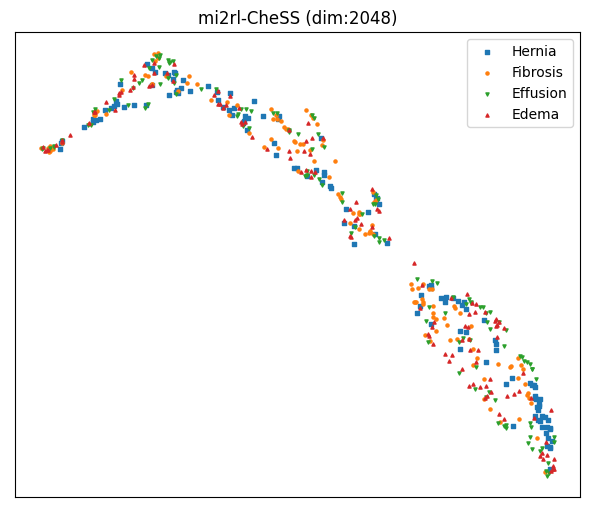

In [17]:
plt.figure(0, figsize=(6, 5), dpi=100)
markers = ["s", "o", "v", "^", "P", "x", "*"]
for i, idx in enumerate(sorted(np.unique(np.argmax(dataset.labels, axis=1)))):
    name = dataset.pathologies[idx]
    
    mask = np.argmax(dataset.labels, axis=1) == idx
    
    plt.scatter(X_embedded[:,0][mask], 
                X_embedded[:,1][mask], 
                s=5,
                label=name,
                marker=markers[i]
                );
plt.legend();
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.tight_layout()
plt.title(f'{model} (dim:{data.shape[1]})');
fname = (f'{model} (dim:{data.shape[1]})').lower()
for rm in [" ", "(", ")", ":"]:
    fname = fname.replace(rm, "_")
print(fname)